In [1]:
import warnings
import torch

%matplotlib inline
warnings.filterwarnings('ignore')
torch.set_grad_enabled(False);

In [2]:
hidden_dim = 256
dropout = 0.1
nheads = 8
dim_feedforward = 2048
enc_layers = 6
dec_layers = 6
pre_norm = False
num_classes = 91  #coco
num_queries = 100
aux_loss = False

In [3]:
from models.position_encoding import PositionEmbeddingSine
from models.backbone import Backbone, Joiner

backbone = Backbone('resnet50', True, False, False)

N_steps = hidden_dim // 2
position_embedding = PositionEmbeddingSine(N_steps, normalize=True)
model = Joiner(backbone, position_embedding)
model.num_channels = backbone.num_channels
backbone = model

In [4]:
from models.transformer import Transformer

transformer = Transformer(
    d_model=hidden_dim,
    dropout=dropout,
    nhead=nheads,
    dim_feedforward=dim_feedforward,
    num_encoder_layers=enc_layers,
    num_decoder_layers=dec_layers,
    normalize_before=pre_norm,
    return_intermediate_dec=True,
)

In [5]:
from models.detr import DETR

model = DETR(
    backbone,
    transformer,
    num_classes=num_classes,
    num_queries=num_queries,
    aux_loss=aux_loss,
)

In [6]:
import torch

model.load_state_dict(torch.load("E:\Development Program\Pycharm Program\detr\detr-r50-e632da11.pth")['model']);

<All keys matched successfully>

In [6]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [23]:
from predict_utils import transform, rescale_bboxes

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.09

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

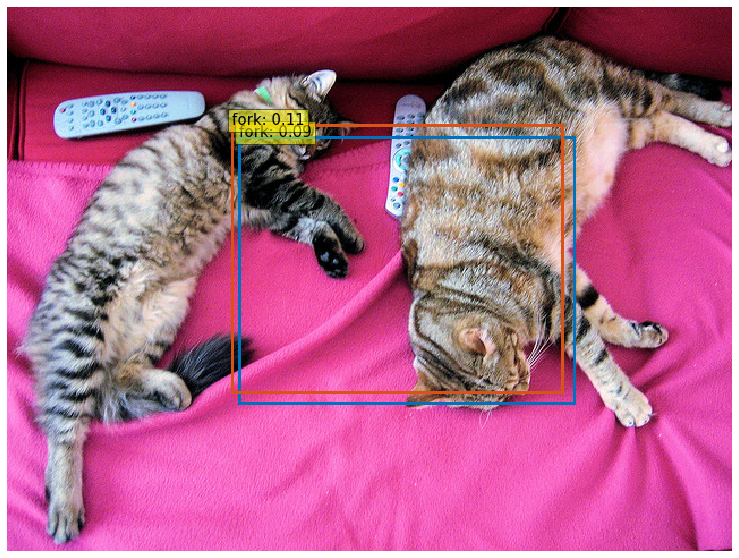

In [24]:
from predict_utils import plot_results

plot_results(im, probas[keep], bboxes_scaled)

In [25]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

In [26]:
enc_attn_weights.size()


torch.Size([1, 850, 850])

In [27]:
dec_attn_weights.size()

torch.Size([1, 100, 850])

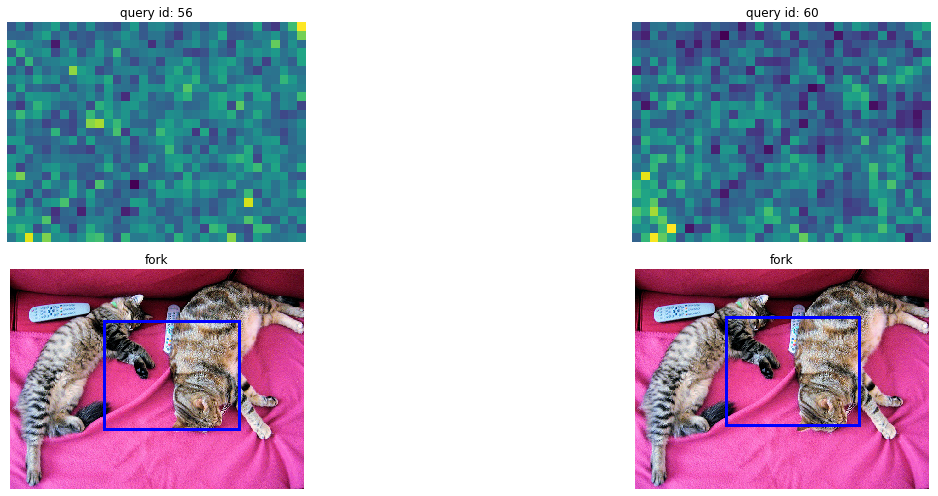

In [28]:
from predict_utils import COLORS, CLASSES
from matplotlib import pyplot as plt

# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

In [29]:
# output of the CNN
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)

Encoder attention:       torch.Size([850, 850])
Feature map:             torch.Size([1, 2048, 25, 34])


In [30]:
# get the HxW shape of the feature maps of the CNN
shape = f_map.tensors.shape[-2:]
# and reshape the self-attention to a more interpretable shape
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention:", sattn.shape)

Reshaped self-attention: torch.Size([25, 34, 25, 34])


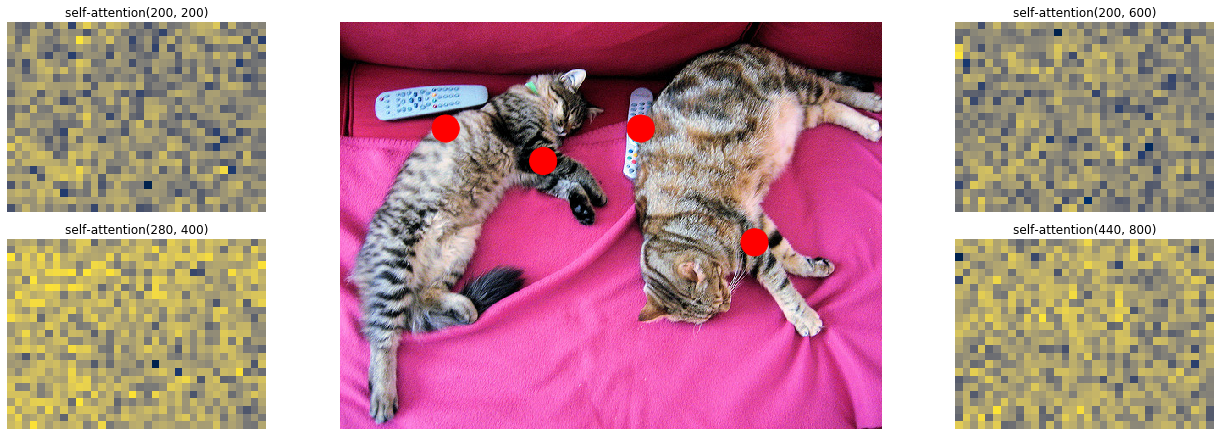

In [31]:
# downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
fact = 32

# let's select 4 reference points for visualization
idxs = [(200, 200), (280, 400), (200, 600), (440, 800),]

# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# for each one of the reference points, let's plot the self-attention
# for that point
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# and now let's add the central image, with the reference points as red circles
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')

In [32]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output
class AttentionVisualizer:
    def __init__(self, model, transform):
        self.model = model
        self.transform = transform

        self.url = ""
        self.cur_url = None
        self.pil_img = None
        self.tensor_img = None

        self.conv_features = None
        self.enc_attn_weights = None
        self.dec_attn_weights = None

        self.setup_widgets()

    def setup_widgets(self):
        self.sliders = [
            widgets.Text(
                value='http://images.cocodataset.org/val2017/000000039769.jpg',
                placeholder='Type something',
                description='URL (ENTER):',
                disabled=False,
                continuous_update=False,
                layout=widgets.Layout(width='100%')
            ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='X coordinate', value=0.72,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')
                        ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='Y coordinate', value=0.40,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')),
            widgets.Checkbox(
              value=False,
              description='Direction of self attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          ),
            widgets.Checkbox(
              value=True,
              description='Show red dot in attention',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          )
        ]
        self.o = widgets.Output()

    def compute_features(self, img):
        model = self.model
        # use lists to store the outputs via up-values
        conv_features, enc_attn_weights, dec_attn_weights = [], [], []

        hooks = [
            model.backbone[-2].register_forward_hook(
                lambda self, input, output: conv_features.append(output)
            ),
            model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
                lambda self, input, output: enc_attn_weights.append(output[1])
            ),
            model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
                lambda self, input, output: dec_attn_weights.append(output[1])
            ),
        ]
        # propagate through the model
        outputs = model(img)

        for hook in hooks:
            hook.remove()

        # don't need the list anymore
        self.conv_features = conv_features[0]
        self.dec_attn_weights = dec_attn_weights[0]
        # get the HxW shape of the feature maps of the CNN
        shape = self.conv_features['0'].tensors.shape[-2:]
        # and reshape the self-attention to a more interpretable shape
        self.enc_attn_weights = enc_attn_weights[0].reshape(shape + shape)

    def compute_on_image(self, url):
        if url != self.url:
            self.url = url
            self.pil_img = Image.open(requests.get(url, stream=True).raw)
            # mean-std normalize the input image (batch-size: 1)
            self.tensor_img = self.transform(self.pil_img).unsqueeze(0)
            self.compute_features(self.tensor_img)

    def update_chart(self, change):
        with self.o:
            clear_output()

            # j and i are the x and y coordinates of where to look at
            # sattn_dir is which direction to consider in the self-attention matrix
            # sattn_dot displays a red dot or not in the self-attention map
            url, j, i, sattn_dir, sattn_dot = [s.value for s in self.sliders]

            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))
            self.compute_on_image(url)

            # convert reference point to absolute coordinates
            j = int(j * self.tensor_img.shape[-1])
            i = int(i * self.tensor_img.shape[-2])

            # how much was the original image upsampled before feeding it to the model
            scale = self.pil_img.height / self.tensor_img.shape[-2]

            # compute the downsampling factor for the model
            # it should be 32 for standard DETR and 16 for DC5
            sattn = self.enc_attn_weights
            fact = 2 ** round(math.log2(self.tensor_img.shape[-1] / sattn.shape[-1]))

            # round the position at the downsampling factor
            x = ((j // fact) + 0.5) * fact
            y = ((i // fact) + 0.5) * fact

            axs[0].imshow(self.pil_img)
            axs[0].axis('off')
            axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))

            idx = (i // fact, j // fact)

            if sattn_dir:
                sattn_map = sattn[idx[0], idx[1], ...]
            else:
                sattn_map = sattn[..., idx[0], idx[1]]

            axs[1].imshow(sattn_map, cmap='cividis', interpolation='nearest')
            if sattn_dot:
                axs[1].add_patch(plt.Circle((idx[1],idx[0]), 1, color='r'))
            axs[1].axis('off')
            axs[1].set_title(f'self-attention{(i, j)}')

            plt.show()

    def run(self):
      for s in self.sliders:
          s.observe(self.update_chart, 'value')
      self.update_chart(None)
      url, x, y, d, sattn_d = self.sliders
      res = widgets.VBox(
      [
          url,
          widgets.HBox([x, y]),
          widgets.HBox([d, sattn_d]),
          self.o
      ])
      return res

In [33]:
w = AttentionVisualizer(model, transform)
w.run()